Тестовые функции.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.widgets import Slider

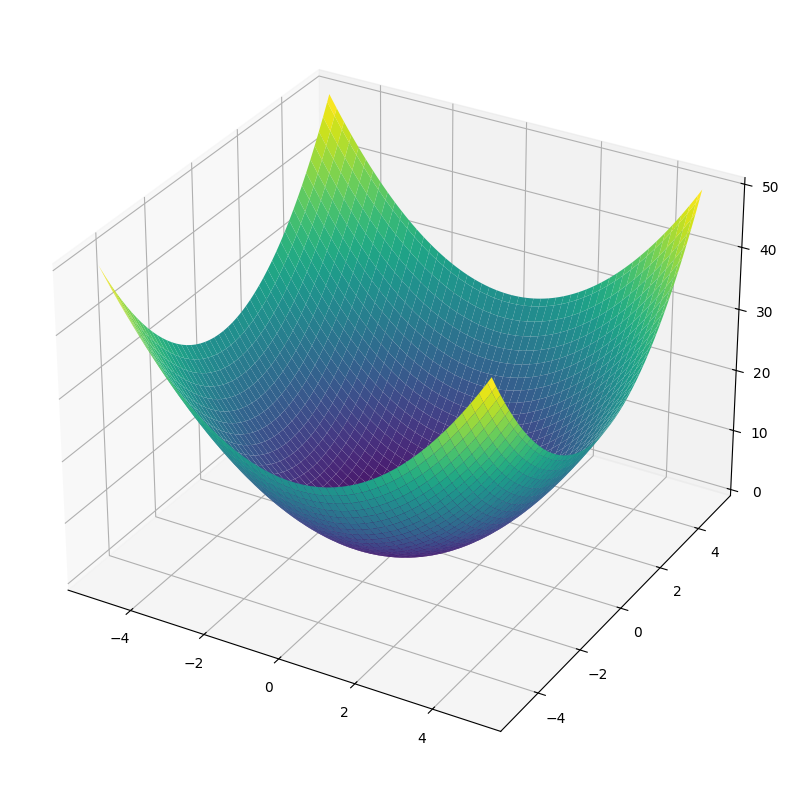

In [2]:
fig = plt.figure(figsize=(25, 10))

# Определяем функцию, которую хотим визуализировать
def func(x, y):
  return (x**2 + y**2)

# Создаем сетку для графика
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = func(X, Y)

# Создаем 3D-график

ax = fig.add_subplot(111, projection='3d')
plot = ax.plot_surface(X, Y, Z, cmap='viridis')

# Отображаем график
plt.show()
